# Introduction to LIGO Skymaps
In this first tutorial we will learn the basics of LIGO sky localiztion probability maps (skymaps).

We will cover a) downloading and reading in the Flexible Image Transport System (FITS) files, b) getting header information for skymaps, c) getting probabilities given line of sight (right ascension/declination), d) finding the maximum probability density pixel, e) creating skymap plots with galactic coordinates, f) selecting the 50% and 90% probability regions, and g) down-sampling the map to coarser resolutions.

## Setting up the Python Environment
The following packages are needed for working with LIGO skymaps: Astropy, Healpy, and Numpy. We will also utilize Matplotlib, Scipy, and Astroquery. All of these packages can be installed using Pip.

In [1]:
# -- For Google Colab
#! pip install -q astropy astroquery healpy matplotlib scipy

All LIGO skymaps are stored as FITS files. The FITS files contain a single binary table that represent a HEALPix (Hierarchical Equal Area isoLatitude Pixelization) all-sky image.
For compact binary mergers, 3-D skymaps (distance + directional information) are provided. These tables have four columns: PROB, DISTMU, DISTSTD, and DISTNORM.
For unmodelled triggers, 2-D skymaps are generated with only directional information. These tables only have one column.

More on this later.... Now that we have installed the packages successfully, let us try importing the necessary packages for working with the HEALPix files.

## Import necessary packages 

In [2]:
import healpy as hp # for working with HEALPix files
import numpy as np # needed for vector operations
from matplotlib import pyplot as plt # plotting skymaps
from scipy.stats import norm # probability functions

We will download a skymap from the BNS merger event, GW170817.
Specifically, we will use the publication LALInference skymap.
All skymaps relevant for this event released from the LIGO-Virgo side can be found here: https://dcc.ligo.org/LIGO-G1701985/public

In [4]:
from astropy.utils.data import download_file
url = ('https://dcc.ligo.org/public/0146/G1701985/001/LALInference_v2.fits.gz')
# This is the publication LALInference localization
filename = download_file(url, cache=True)

Now, when we read in the HEALPix file with Healpy, we get a skymap and a header. The skymap contains the first column which is the probability sky map. This is the probability that the source is contained in pixel $i$, centered on the direction $\vec{n}_i$. The units are pixel$^{-1}$. For 3D skymaps, 3 additional columns remain which are DISTMU, DISTSTD, and DISTNORM.

## Reading in the skymap and header with Healpy

In [5]:
prob, header = hp.read_map(filename, h=True) # reading in the first column which is the probability skymap and the header

Now, because we are working with a 3D skymap, we will read in distance information as well: distmu and distsigma (the ansatz location and scale parameters of condition distance distribution in direction $\vec{n}_i$), and distnorm (the ansatz normalization coefficient).

In [6]:
distmu, distsigma, distnorm = hp.read_map(filename, field=[1,2,3])

Because we read in the header (which contains relevant metadata about the event and the skymap), we will print it explicitly. Often, the circulars written by the LIGO and Virgo Collaborations contain information from the skymap headers.

In [7]:
header

[('XTENSION', 'BINTABLE'),
 ('BITPIX', 8),
 ('NAXIS', 2),
 ('NAXIS1', 32),
 ('NAXIS2', 50331648),
 ('PCOUNT', 0),
 ('GCOUNT', 1),
 ('TFIELDS', 4),
 ('TTYPE1', 'PROB'),
 ('TFORM1', 'D'),
 ('TUNIT1', 'pix-1'),
 ('TTYPE2', 'DISTMU'),
 ('TFORM2', 'D'),
 ('TUNIT2', 'Mpc'),
 ('TTYPE3', 'DISTSIGMA'),
 ('TFORM3', 'D'),
 ('TUNIT3', 'Mpc'),
 ('TTYPE4', 'DISTNORM'),
 ('TFORM4', 'D'),
 ('TUNIT4', 'Mpc-2'),
 ('PIXTYPE', 'HEALPIX'),
 ('ORDERING', 'NESTED'),
 ('COORDSYS', 'C'),
 ('NSIDE', 2048),
 ('INDXSCHM', 'IMPLICIT'),
 ('OBJECT', 'G298107'),
 ('REFERENC', 'https://gracedb.ligo.org/events/G298107'),
 ('INSTRUME', 'H1,L1,V1'),
 ('DATE-OBS', '2017-08-17T12:41:04.444458'),
 ('MJD-OBS', 57982.52852366262),
 ('DATE', '2017-08-17T16:11:42.000000'),
 ('CREATOR', 'BAYESTAR'),
 ('ORIGIN', 'LIGO/Virgo'),
 ('RUNTIME', 15.0),
 ('DISTMEAN', 39.76999609489005),
 ('DISTSTD', 8.308435058808682),
 ('LOGBCI', 13.64819688928804),
 ('LOGBSN', 261.0250944470225),
 ('VCSVERS', 'LALInference 1.9.4.1'),
 ('VCSSTAT', 'CLE

Above in the header, DISTMEAN is the posterior mean distance in Mpc and DISTSTD is the posterior standard deviation of the distance in Mpc.

Next, it will be useful for us to have the HEALPix resolution on hand.

In [8]:
npix = len(prob)
nside = hp.npix2nside(npix)
npix, nside

(50331648, 2048)

Another way to get the same information is to use the Healpy functions get_map_size and get_nside.

In [9]:
hp.get_map_size(prob)

50331648

In [10]:
hp.get_nside(prob)

2048

The relationship between $npix$ and $nside$ is $npix = 12 * nside^2$.

## Finding the maximum probability density pixel

Sometimes it is useful to find the maximum probability density pixel.

In [11]:
maxpix = np.argmax(prob)
maxpix

32883013

We want to compute the probability per deg$^2$ contained in this pixel.
To find this, we first need Healpy to tell us the area per pixel in steradians at the current HEALPix resolution.

In [12]:
pixarea = hp.nside2pixarea(nside)
pixarea

2.4967135219492856e-07

Note, the $pixarea$ is the same as the solid angle of the sphere divided by the number of pixels, $4 \pi/npix$.

In [13]:
pixarea == 4*np.pi/npix

True

We can also get the $pixarea$ in deg$^2$.

In [14]:
pixarea_deg2 = hp.nside2pixarea(nside, degrees=True)
pixarea_deg2

0.0008196227004015301

We can also compute this by using the conversion from steradians to deg$^2$: $1$sr $= (180/\pi)^2$ deg$^2$.

In [15]:
pixarea_deg2 == pixarea*(180/np.pi)**2

True

Thus, if we want to compute the probability per steradian or probability per deg$^2$, we just divide the probability contained in maxpix by the area per pixel.

In [16]:
dp_dA = prob[maxpix]/pixarea
dp_dA # Probability per steradian

256.88500373329117

In [17]:
dp_dA_deg2 = prob[maxpix]/pixarea_deg2
dp_dA_deg2 # Probability per deg^2

0.07825164701913416

## 2D Probability in a Given Line of Sight

We want to be able to compute the probability per deg$^2$ that the source is in a given direction.
Let us take the following equatorial coordinates.

In [18]:
ra, dec = 197.45, -23.38 # Coordinates of NGC 4993

Healpy uses spherical coordinates $(\theta, \phi)$ with $\theta \in [0, \pi]$ being the colatitude from the north celestial pole in radians, and $\phi \in [0, 2\pi)$ being the right ascension in radians.

In [19]:
# Converting to radians
theta = 0.5*np.pi - np.deg2rad(dec)
phi = np.deg2rad(ra)
theta, phi

(1.9788543059111707, 3.4461526080628033)

Now, we look up the index of the HEALPix pixel that contains this direction.

In [20]:
ipix = hp.ang2pix(nside, theta, phi)
ipix

35152269

Now, we want to compute the probability contained within this ipix pixel. (This is a repeat of what was done above.)

In [21]:
dp_dA = prob[ipix]/pixarea # Probability per steradian
dp_dA

113.84506839221187

In [22]:
dp_dA_deg2 = prob[ipix]/pixarea_deg2 # Probability per deg^2
dp_dA_deg2

0.03467919098907695

## Conditional Distance Distribution along a Line of Sight

Next, let us calculate the conditional distance distribution along a given line of sight. In other words, this is the probability per unit distance under the assumption that the source is in a given direction.

We first lay out a grid in distance along that line of sight.

In [23]:
r = np.linspace(0,80,100) # Returns 100 evenly spaced numbers between 0 and 80

Now, we plug everyting into the ansatz distribution. The probability that a source is within pixel $i$ and at a distance between $r$ and $r + dr$ is:
\begin{equation*}
P(r, \vec{n}_i) dr = \rho_i \frac{\hat{N}_i}{\sqrt{2\pi}\hat{\sigma}_i} \text{exp} \left[-\frac{(r-\hat{\mu}_i)^2}{2\hat{\sigma}_i^2} \right] r^2 dr
\end{equation*}


In [24]:
dp_dr = r**2 * distnorm[ipix] * norm(distmu[ipix], distsigma[ipix]).pdf(r)

Now, we can plot the result.

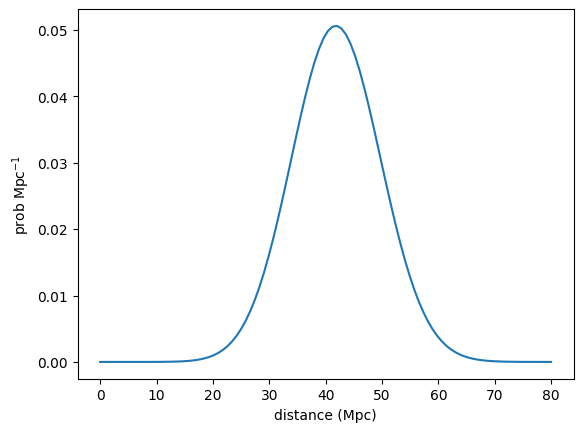

In [25]:
plt.plot(r, dp_dr)
plt.xlabel('distance (Mpc)')
plt.ylabel('prob Mpc$^{-1}$')
plt.show()

## Probability per Unit Volume at a Point 

Now, we can calculate the probability density per Mpc$^3$ at a point. We can use the same right ascension and declination as above and the distance to NGC 4993, which is 40 Mpc.

In [26]:
r = 40

In [27]:
dp_dV = prob[ipix]*distnorm[ipix]*norm(distmu[ipix], distsigma[ipix]).pdf(r)/pixarea
dp_dV

0.0035090602969264544

## Creating skymap plots with equatorial coordinates

Now we wish to create the type of figures that appear in the LIGO/Virgo publications.

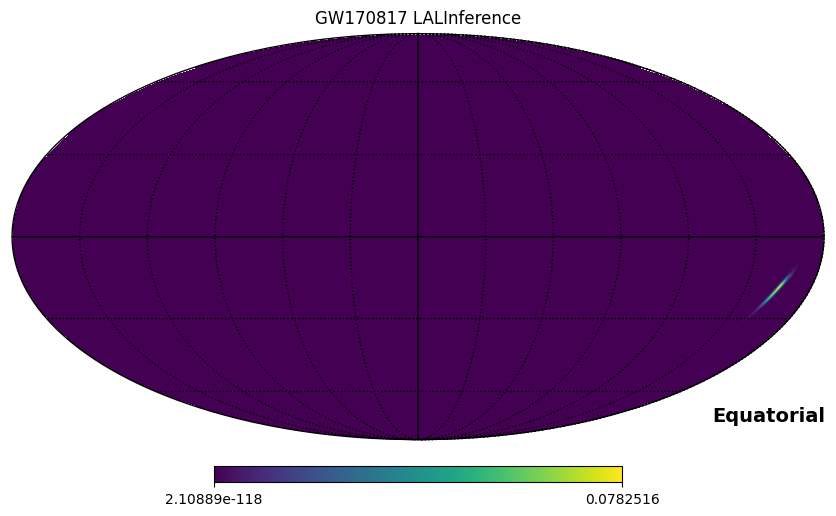

In [28]:
probperdeg2 = prob/pixarea_deg2
hp.mollview(probperdeg2, coord=['C'], title='GW170817 LALInference', max=np.max(probperdeg2))
hp.graticule(local=True)
plt.show()

# References

Please see the following papers/supplements/software repositories for in-depth information on LIGO/Virgo skymaps.

1. Going the Distance: Mapping Host Galaxies of LIGO and Virgo Sources in Three Dimensions Using Local Cosmography and Targeted Follow-up. Singer et al. iopscience.iop.org/article/10.3847/2041-8205/829/1/L15/meta

2. Supplement: "Going the Distance". Singer et al. iopscience.iop.org/article/10.3847/0067-0049/226/1/10/meta

3. https://git.ligo.org/leo-singer/ligo.skymap

4. https://github.com/ggreco77/GWSky